# Libraries

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
import models
import modelConv2d
import loss_func
import train
import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import optimizer_Factory as of
import Data.genData as genData
import custom_plots as cp
import Visual_utils as vu
import torchvision

# Pendulum

### Load Data

<Figure size 640x480 with 0 Axes>

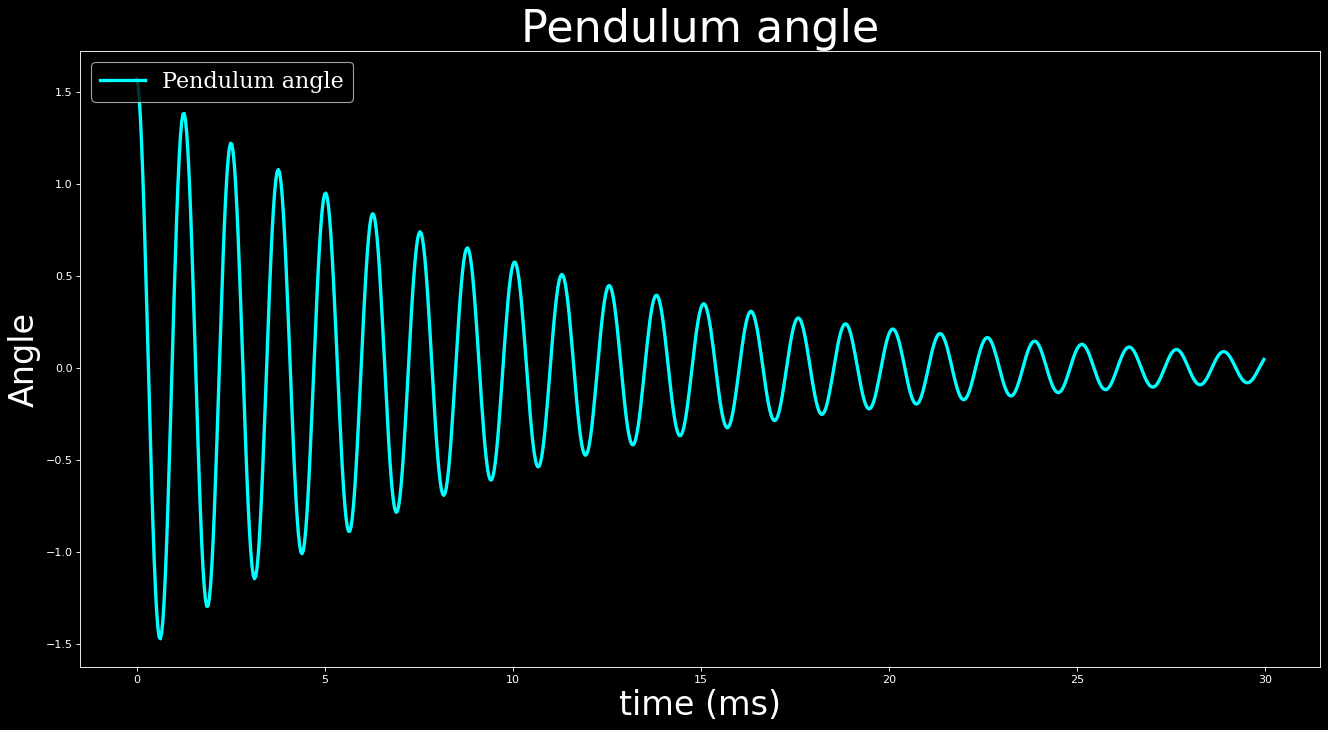

In [3]:
g=9.81
L=1
x0=np.pi/2
x1=np.pi/2.5
t,a = genData.generatePendulumA(g,L,x0, x1)

In [4]:

train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)

### Visualizations

Image shape: (500, 260)


<Figure size 640x480 with 0 Axes>

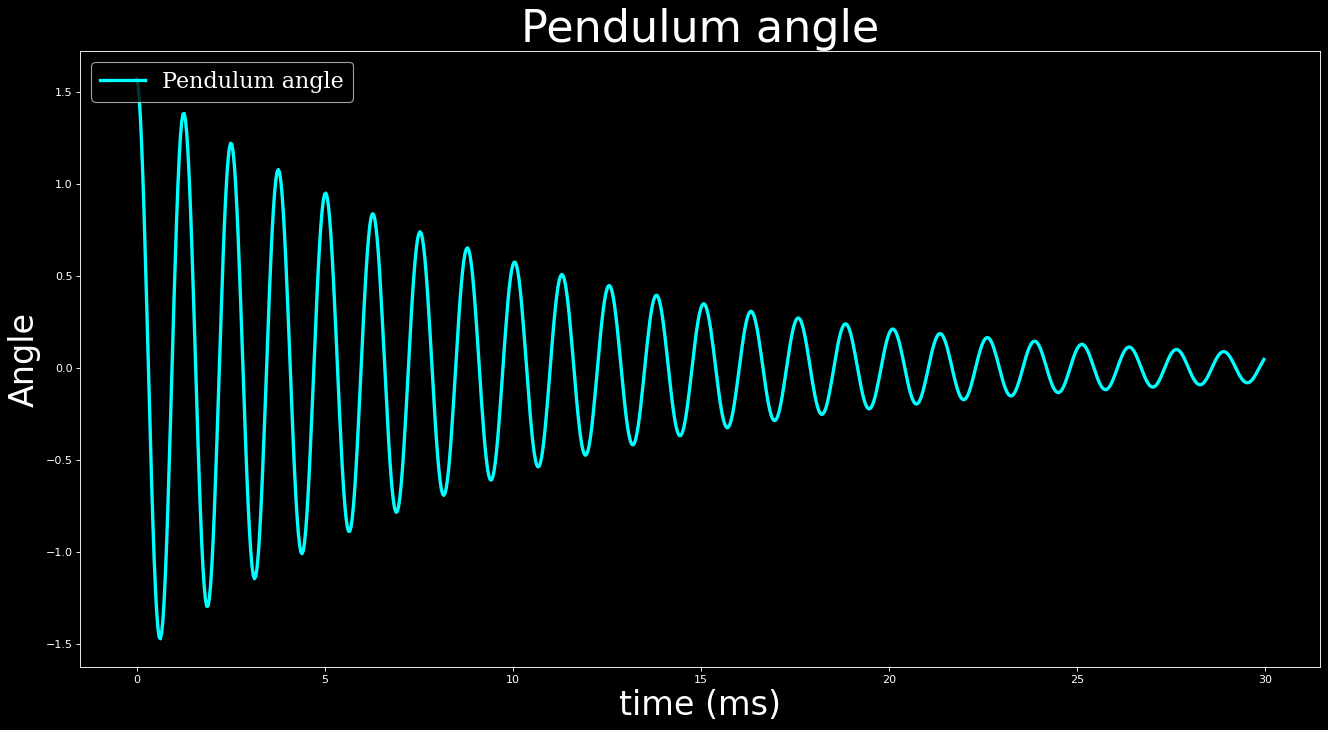

In [2]:
img = genData.create_pendulum_image(90)
print("Image shape:", img.size)
genData.generateVideo()

<Figure size 640x480 with 0 Axes>

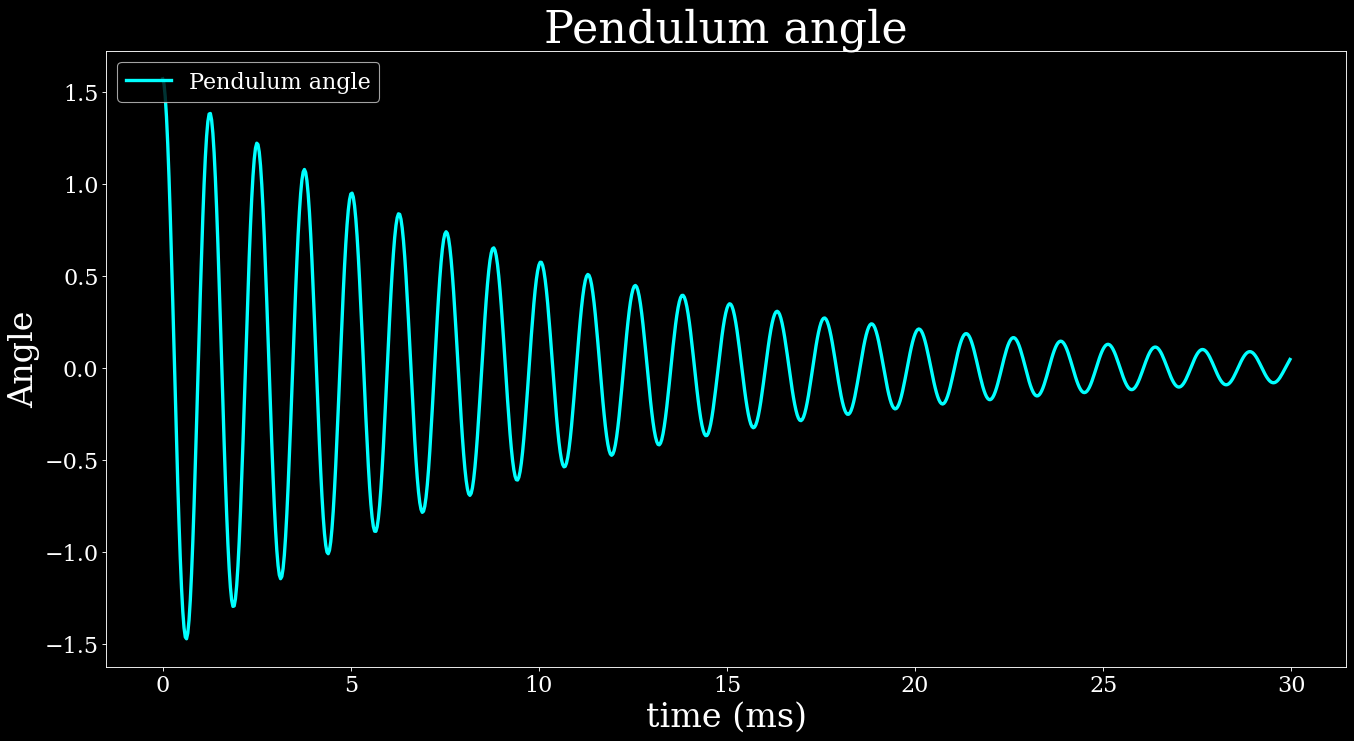

In [3]:
genData.generateVideo()

In [68]:
###### uncoment to see dataset example  ######

# data_iter = iter(train_dataloader)

# # Get a batch of data
# batch_data = next(data_iter)

# # Get the shape of the batch
# batch_shape = batch_data[0][0].shape

# print("Batch shape:", batch_shape)

# testimage = batch_data[0][0][0]
# cmap = plt.cm.get_cmap('Greys_r', 256)

# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][29]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][30]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][31]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

#cp.plotMatrix(testimage.permute(1, 2, 0),'xlabel', 'ylabel','title', 'name', styleDark = True)

In [69]:
###### uncoment to see dataset example  ######
# im1 = genData.create_pendulum_image(0.1)
# print("Image shape:", im1.size)
# plt.figure()
# plt.imshow(im1)
# from torchvision import transforms
# convert_tensor = transforms.ToTensor()

# tensor_image = convert_tensor(im1)
# # Print tensor image shape
# print("Tensor image shape:", tensor_image.shape)
# # print max value torch tensor
# print("Max value:", torch.max(tensor_image))
# plt.figure()
# plt.imshow(  tensor_image.permute(1, 2, 0)  )

### Visualization 3D dataset

Batch shape: torch.Size([32, 3, 260, 500])
torch.Size([3, 260, 500])


C:\Users\aleja\AppData\Local\Temp\ipykernel_38492\1250452360.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


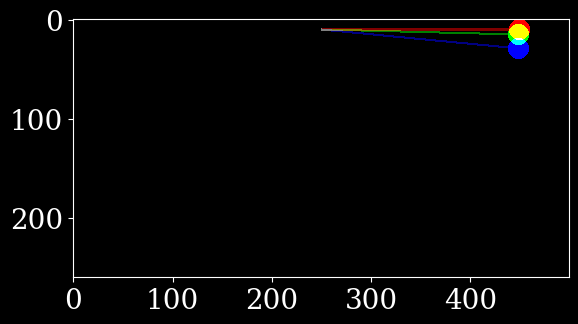

In [4]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)

data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][29]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][30]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][31]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

# cp.plotMatrix(testimage.permute(1, 2, 0),'xlabel', 'ylabel','title', 'name', styleDark = True)

### Models

In [32]:

#train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)
modelAE = models.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

Using device: cuda
torch.Size([32, 1, 3, 260, 500])
3
torch.Size([32, 3, 60, 120])
torch.Size([32, 21600])
torch.Size([32, 3])
torch.Size([32, 1])
torch.Size([32, 3, 60, 120])
5
torch.Size([32, 2, 121, 241])
torch.Size([32, 2, 121, 241])
torch.Size([32, 1, 243, 483])
torch.Size([32, 1, 243, 483])


RuntimeError: non-positive stride is not supported

#### Visual Test

In [25]:
visual_loader= loader.getLoader(a, split=False)

In [58]:
vu.visualize(modelAE, visual_loader)

Frame 0 of 898.0
Frame 1 of 898.0
Frame 2 of 898.0
Frame 3 of 898.0
Frame 4 of 898.0
Frame 5 of 898.0
Frame 6 of 898.0
Frame 7 of 898.0
Frame 8 of 898.0
Frame 9 of 898.0
Frame 10 of 898.0
Frame 11 of 898.0
Frame 12 of 898.0
Frame 13 of 898.0
Frame 14 of 898.0
Frame 15 of 898.0
Frame 16 of 898.0
Frame 17 of 898.0
Frame 18 of 898.0
Frame 19 of 898.0
Frame 20 of 898.0
Frame 21 of 898.0
Frame 22 of 898.0
Frame 23 of 898.0
Frame 24 of 898.0
Frame 25 of 898.0
Frame 26 of 898.0
Frame 27 of 898.0
Frame 28 of 898.0
Frame 29 of 898.0
Frame 30 of 898.0
Frame 31 of 898.0
Frame 32 of 898.0
Frame 33 of 898.0
Frame 34 of 898.0
Frame 35 of 898.0
Frame 36 of 898.0
Frame 37 of 898.0
Frame 38 of 898.0
Frame 39 of 898.0
Frame 40 of 898.0
Frame 41 of 898.0
Frame 42 of 898.0
Frame 43 of 898.0
Frame 44 of 898.0
Frame 45 of 898.0
Frame 46 of 898.0
Frame 47 of 898.0
Frame 48 of 898.0
Frame 49 of 898.0
Frame 50 of 898.0
Frame 51 of 898.0
Frame 52 of 898.0
Frame 53 of 898.0
Frame 54 of 898.0
Frame 55 of 898.0
Fr

<Figure size 640x480 with 0 Axes>

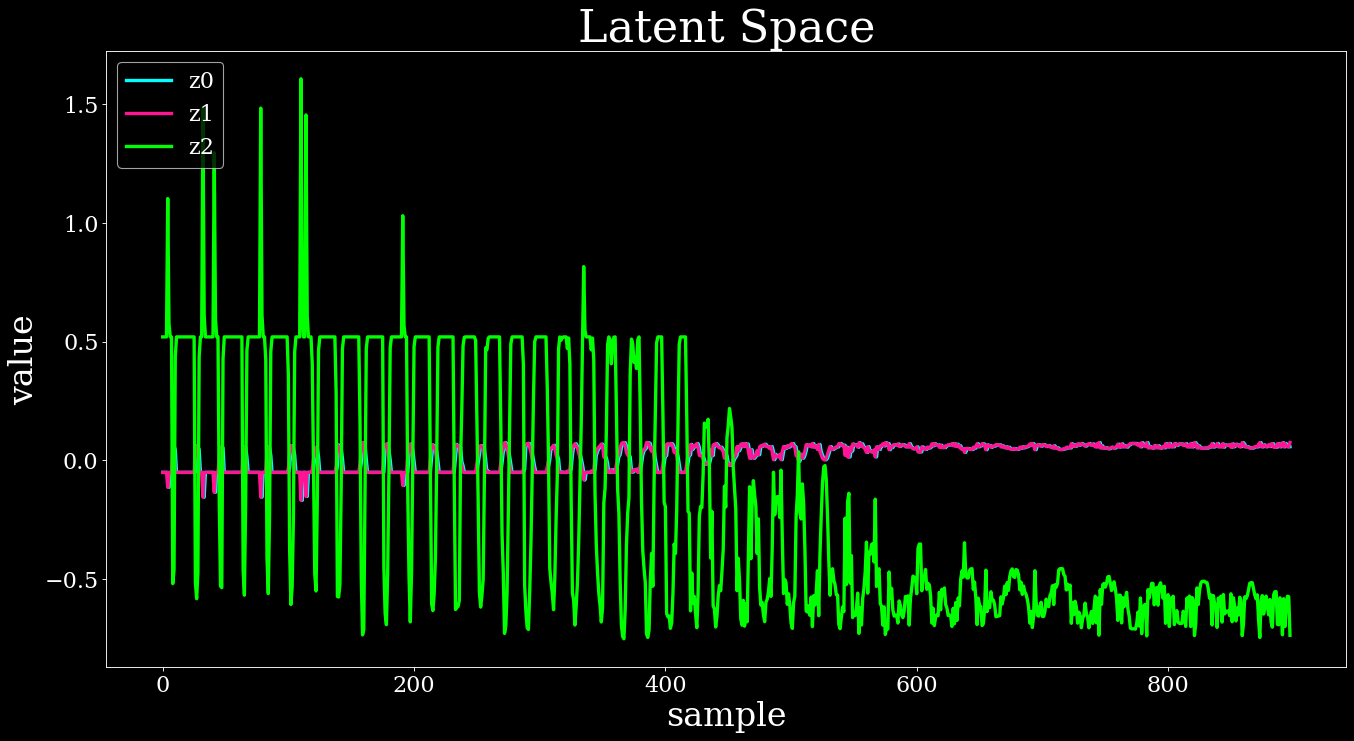

In [44]:
vu.CompareLatent(modelAE, visual_loader)

### Model Conv2d

In [6]:
modelAE = modelConv2d.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

Using device: cpu
epoch: 2 	 training loss: 0.13853664113127667 	 validation loss: 0.12691617260376611
epoch: 4 	 training loss: 0.09852955166412436 	 validation loss: 0.0897314337392648
epoch: 6 	 training loss: 0.06866462399130283 	 validation loss: 0.062237998470664024
epoch: 8 	 training loss: 0.047146976803955826 	 validation loss: 0.04262214402357737
epoch: 10 	 training loss: 0.032222753471654396 	 validation loss: 0.029163331724703312
epoch: 12 	 training loss: 0.022294027325899704 	 validation loss: 0.020314236792425316
epoch: 14 	 training loss: 0.015978454733672348 	 validation loss: 0.014755765131364265
epoch: 16 	 training loss: 0.01214738344044789 	 validation loss: 0.01142825356995066


: 

: 